# Notebook Description
This notebook shows the experiment of using data from the mixed scenario, with non-shared weights, and the CNN model.

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

# Set options and load file
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext google.colab.data_table
from google.colab import data_table
from google.colab import drive

drive.mount('/content/drive')
os.chdir("YOUR FOLDER HERE")
raw_data_folder = './data/raw/'
interim_data_folder = './data/interim/'
processed_data_folder = './data/processed/'
models_folder = './models/'

Mounted at /content/drive


In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import Dot, LSTM, Bidirectional, Reshape,Flatten
from keras.layers.core import Dense
from keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D

!pip install keras_nlp
from keras_nlp.layers import PositionEmbedding


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 26.7 MB/s 
     |████████████████████████████████| 5.9 MB 39.0 MB/s 
     |████████████████████████████████| 578.0 MB 17 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 4.6 MB 63.8 MB/s 


In [ ]:
# Load Data
# -------------
alphabet = 'eainlrsotdychmbugkjpfvzwxq.ó'
print('Alphabet:')
print(alphabet)

# Original dfs
train_df = pd.read_csv(interim_data_folder + 'train_df_mixed_shuffled.csv', index_col=0)
validation_df = pd.read_csv(interim_data_folder + 'validation_df_mixed_shuffled.csv', index_col=0)
test_df = pd.read_csv(interim_data_folder + 'test_df_mixed_shuffled.csv', index_col=0)

# tokenized dfs
train_data_names = np.loadtxt(processed_data_folder + 'train_mixed_data_names.txt', dtype = int)
train_data_nicknames = np.loadtxt(processed_data_folder + 'train_mixed_data_nicknames.txt', dtype = int)
validation_data_names = np.loadtxt(processed_data_folder + 'validation_mixed_data_names.txt', dtype = int)
validation_data_nicknames = np.loadtxt(processed_data_folder + 'validation_mixed_data_nicknames.txt', dtype = int)
test_data_names = np.loadtxt(processed_data_folder + 'test_mixed_data_names.txt', dtype = int)
test_data_nicknames = np.loadtxt(processed_data_folder + 'test_mixed_data_nicknames.txt', dtype = int)

# targets
train_targets = np.loadtxt(processed_data_folder + 'train_mixed_targets.txt', dtype = int)
validation_targets = np.loadtxt(processed_data_folder + 'validation_mixed_targets.txt', dtype = int)
test_targets = np.loadtxt(processed_data_folder + 'test_mixed_targets.txt', dtype = int)

print(train_df['name'].tolist()[1])

train_df.iloc[:5]

Alphabet:
eainlrsotdychmbugkjpfvzwxq.ó
flora


,name,nickname,y
4918,theodore,cy,0
4225,flora,belle,0
6871,isabella,bel,1
1136,jo,ara,0
1754,clement,jessie,0


In [ ]:
# print((train_df['y'].values == train_targets))
print(train_df.iloc[:5])
print(train_data_names[:5],'\n')
print(train_data_nicknames[:5])


          name nickname  y
4918  theodore       cy  0
4225     flora    belle  0
6871  isabella      bel  1
1136        jo      ara  0
1754   clement   jessie  0
[[ 9 13  1  8 10  8  6  1  0  0  0  0  0  0  0]
 [21  5  8  6  2  0  0  0  0  0  0  0  0  0  0]
 [ 3  7  2 15  1  5  5  2  0  0  0  0  0  0  0]
 [19  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [12  5  1 14  1  4  9  0  0  0  0  0  0  0  0]] 

[[12 11  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [15  1  5  5  1  0  0  0  0  0  0  0  0  0  0]
 [15  1  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  6  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [19  1  7  7  3  1  0  0  0  0  0  0  0  0  0]]


In [ ]:
# Define Loss
def cosine_loss(y_true, y_pred, m=0.4, alpha = 0.25):
  # IT IS IMPORTANT TO NOTE THAT IN KERAS CUSTOM LOSS FUNCTIONS, THE ORDER
  # DOES MATTER - KERAS ASSUMES THAT THE FIRST ELEMENT IS y AND THAT THE SECOND
  # IS y_hat.

  y_true=tf.cast(y_true, tf.float32)
  y_pred=tf.cast(y_pred, tf.float32)

  # Create the mask - wherever y_pred<m. Recall that this condition takes place 
  # only for L_ and if E>=m then L_==0. 
  # mask = K.less(y_pred,m)
  mask = K.greater(y_pred,m)
  
  mask = tf.cast(mask,tf.float32)
  mask = mask * (1-y_true)*K.square(y_pred)
  # print(mask)
  L = y_true*alpha*tf.square(1 - y_pred) + mask
  return K.mean(L)



# BCSloss

In [ ]:
tf.random.set_seed(
    2
)

# Define inputs
left_input = Input((15,))
right_input = Input((15,))

embedded_l = Embedding(15, 35)(left_input)
embedded_r = Embedding(15, 35)(right_input)

position_embeddings_l = PositionEmbedding(
    sequence_length=15)(embedded_l)
position_embeddings_r = PositionEmbedding(
    sequence_length=15)(embedded_r)

embedded_l = embedded_l + position_embeddings_l
embedded_r = embedded_r + position_embeddings_r


C_l = tf.keras.layers.Conv1D(filters = 32,
                            kernel_size = 2,
                            padding = 'same',
                            activation = 'relu')(embedded_l)
C_r = tf.keras.layers.Conv1D(filters = 64,
                            kernel_size = 1,
                            padding = 'same',
                            activation = 'relu')(embedded_r)

C_l = Dense(35)(C_l)
C_r = Dense(35)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r


C_l = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 4,
                            padding = 'same',
                            activation = 'sigmoid')(C_l)
C_r = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 4,
                            padding = 'same',
                            activation = 'sigmoid')(C_r)

C_l = Dense(35)(C_l)
C_r = Dense(35)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r

C_l = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'sigmoid')(C_l)
C_r = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'sigmoid')(C_r)

C_l = Dense(35)(C_l)
C_r = Dense(35)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r

C_l = tf.keras.layers.Conv1D(filters = 8,
                            kernel_size = 12,
                            padding = 'same',
                            activation = 'sigmoid')(C_l)
C_r = tf.keras.layers.Conv1D(filters = 8,
                            kernel_size = 12,
                            padding = 'same',
                            activation = 'sigmoid')(C_r)

C_l = Dense(35)(C_l)
C_r = Dense(35)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r

C_l = Dense(1)(C_l)
C_r = Dense(1)(C_r)

# return the cosine similarity E_w
y_pred = Dot(axes=(1), normalize=True)([C_l, C_r]) # y_pred == E_w
y_pred = Flatten()(y_pred)
y_pred = tf.keras.layers.Dense(1, activation="sigmoid")(y_pred)

# define optimizer
opt = keras.optimizers.Adam(learning_rate=0.05)

siamese_net = Model(inputs=[left_input,right_input],outputs=y_pred)
siamese_net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt)
# siamese_net.compile(loss=cosine_loss, optimizer=opt)


print(siamese_net.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 35)       525         ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 15, 35)       525         ['input_2[0][0]']                
                                                                                              

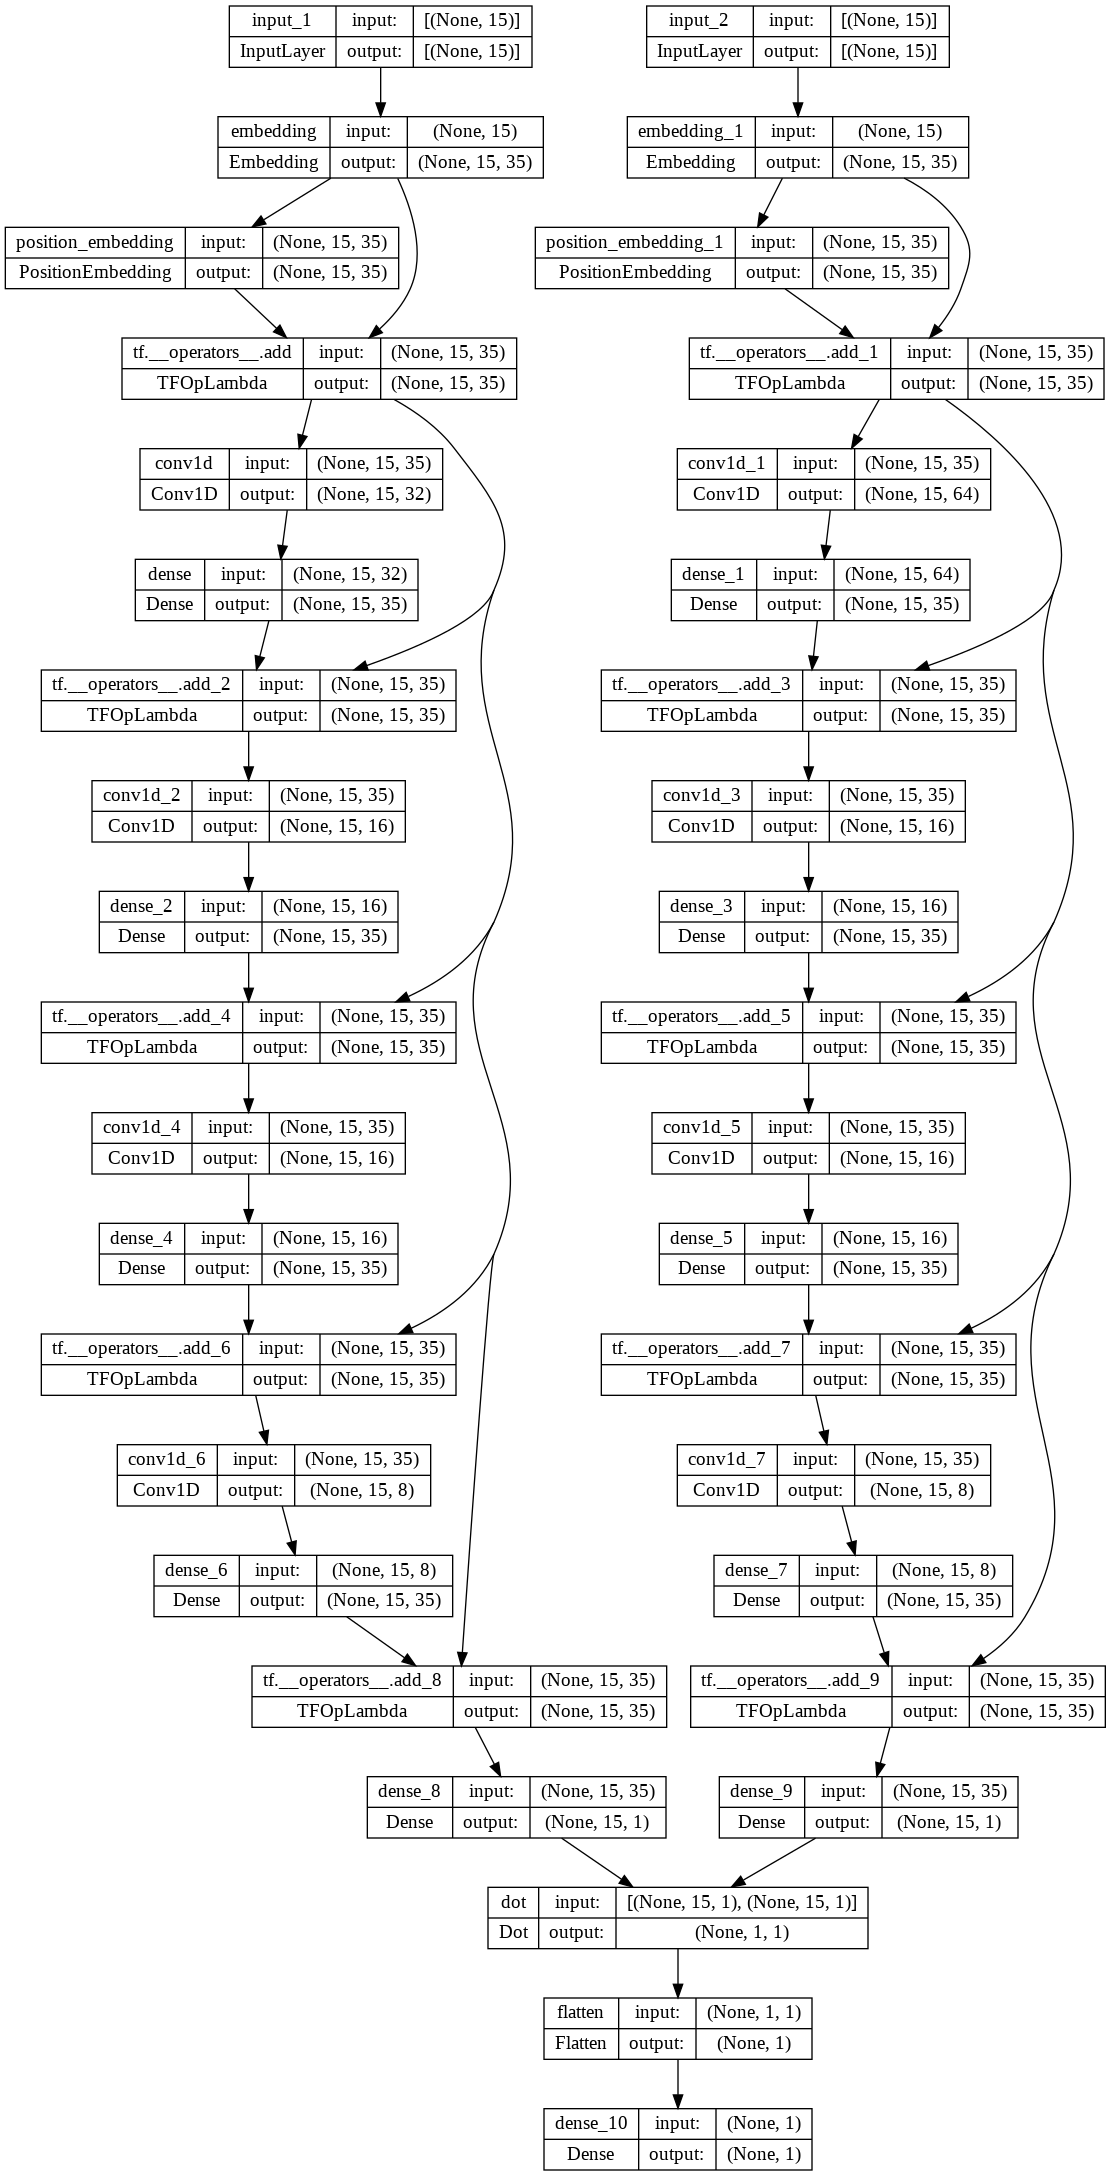

In [ ]:
tf.keras.utils.plot_model(siamese_net, show_shapes=True)

## Training

In [ ]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.optimizers import Adam


# checkpointer
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=75, mode='min'),
      ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=20, min_lr=0.001),
      ModelCheckpoint(filepath=models_folder + 'mixed_val_loss_different_weights_CNN.hdf5', 
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True, 
                      mode='min',
                      restore_best_weights=True)
]

hist = siamese_net.fit(x = [train_data_names, train_data_nicknames],
                     y = train_targets,
                       validation_data=([validation_data_names, validation_data_nicknames], 
                                        validation_targets),
                       epochs = 100,
                       verbose = 1,
                       shuffle = True,
                       batch_size = 16,
                       callbacks=[keras_callbacks])

Epoch 1/100
472/472 [==============================] - ETA: 0s - loss: 0.4997
Epoch 1: val_loss improved from inf to 0.49088, saving model to ./models/mixed_val_loss_different_weights_CNN.hdf5
472/472 [==============================] - 28s 28ms/step - loss: 0.4997 - val_loss: 0.4909 - lr: 0.0500
Epoch 2/100
470/472 [============================>.] - ETA: 0s - loss: 0.4372
Epoch 2: val_loss improved from 0.49088 to 0.42679, saving model to ./models/mixed_val_loss_different_weights_CNN.hdf5
472/472 [==============================] - 8s 16ms/step - loss: 0.4368 - val_loss: 0.4268 - lr: 0.0500
Epoch 3/100
468/472 [============================>.] - ETA: 0s - loss: 0.4148
Epoch 3: val_loss improved from 0.42679 to 0.42438, saving model to ./models/mixed_val_loss_different_weights_CNN.hdf5
472/472 [==============================] - 6s 12ms/step - loss: 0.4134 - val_loss: 0.4244 - lr: 0.0500
Epoch 4/100
472/472 [==============================] - ETA: 0s - loss: 0.4110
Epoch 4: val_loss improve

## Analyze results

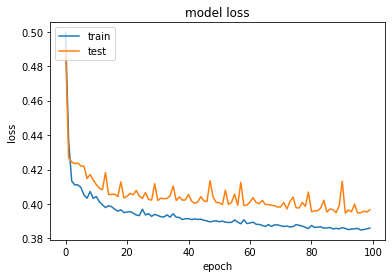

In [ ]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Predict

236/236 [==============================] - 2s 7ms/step
0.8230668200191376


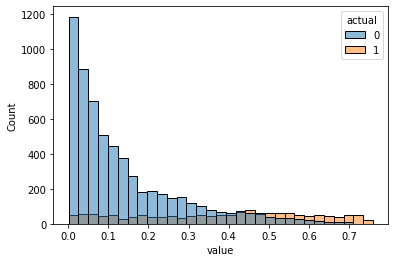

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_different_weights_CNN.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding})

preds_train = pd.DataFrame(model.predict([train_data_names, train_data_nicknames]), columns = ['value'])
preds_train['actual'] = train_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_train['actual'].values, 
                                         preds_train['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_train)

45/45 [==============================] - 1s 9ms/step
0.807511981025967


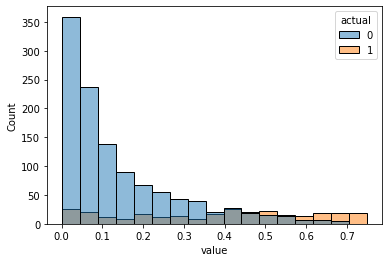

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_different_weights_CNN.hdf5', 
                   custom_objects={'PositionEmbedding': PositionEmbedding})

preds_val = pd.DataFrame(model.predict([validation_data_names, validation_data_nicknames]), 
                         columns = ['value'])
preds_val['actual'] = validation_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_val['actual'].values, 
                                         preds_val['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_val)

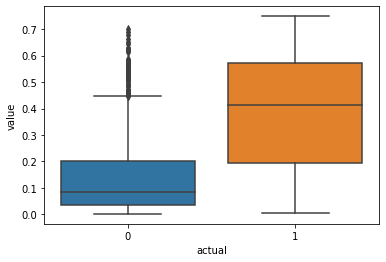

In [ ]:
import seaborn as sns

sns.boxplot(data = preds_val, y='value', x='actual')
# plt.ylim(0.39, 0.395)

# Contrastive Loss